In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
from tqdm import tqdm
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import librosa

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data processing - wav conversion

In [4]:
data_path = os.path.join(os.getcwd(), '../public_dataset/public_dataset/')

In [ ]:
# Convert all webm files to wav files

def convert_webm_to_wav(webm_file):
    wav_file = os.path.splitext(webm_file)[0] + '.wav'
    command = ['ffmpeg', '-i', webm_file, wav_file]
    subprocess.run(command)

In [ ]:
# Multi-threaded conversion
import concurrent.futures

def convert_all_webm_to_wav(folder_path):
    webm_files = [file for file in os.listdir(folder_path) if file.endswith('.webm')]

    with concurrent.futures.ThreadPoolExecutor() as executor, tqdm(total=len(webm_files), desc="Converting") as pbar:
        futures = []

        for webm_file in webm_files:
            future = executor.submit(convert_webm_to_wav, os.path.join(folder_path, webm_file))
            future.add_done_callback(lambda p: pbar.update())
            futures.append(future)

        concurrent.futures.wait(futures)


In [10]:
convert_all_webm_to_wav(data_path)

Converting:   0%|          | 0/25985 [00:00<?, ?it/s]

Converting: 100%|██████████| 25985/25985 [04:59<00:00, 86.62it/s] 


In [12]:
# Delete all webm files

def delete_all_webm(folder_path):
    webm_files = [file for file in os.listdir(folder_path) if file.endswith('.webm')]

    for webm_file in webm_files:
        os.remove(os.path.join(folder_path, webm_file))

delete_all_webm(data_path)

In [11]:
# Get a random json file in the data path
json_file = os.path.join(data_path, np.random.choice(os.listdir(data_path)))

with open(json_file,'r') as f:
    content = json.loads(f.read())

print(content)

{'datetime': '2020-05-10T11:25:39.624938+00:00', 'cough_detected': '0.3891', 'latitude': '43.8', 'longitude': '-79.2'}


## Dataset

In [5]:
SAMPLE_RATE=22050
NUM_SAMPLES=22050
BATCH_SIZE=128
EPOCHS=20

In [6]:
import torchaudio as ta

melspectogram = ta.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

In [7]:
from src.datasets import CoughDataset
from src.architecture.models import CoughMDN, CoughCNN
from src.architecture.architecture import (
    FlattenLinear,
    FlattenLinearMDN,
    ConvolutionalMDN,
    BasicCNN,
)
from src.training import train_loop, mdn_loss, test_loop

In [8]:
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler


In [48]:
cough_dataset = CoughDataset(
    data_path,
    data_path,
    transformation=melspectogram,
    target_sample_rate=SAMPLE_RATE,
    num_samples=NUM_SAMPLES,
    device="cuda",
    # scaler=MinMaxScaler(),
)

In [49]:
from torch.utils.data.dataloader import default_collate

def skip_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return default_collate(batch)


In [50]:
subset_size = int(0.05 * len(cough_dataset))

# Randomly sample 5% of the dataset
subset_dataset, _ = torch.utils.data.random_split(cough_dataset, [subset_size, len(cough_dataset) - subset_size])

# Split the subset into train and test
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size

train_subset, test_subset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoader for train and test subsets
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=skip_collate)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=skip_collate)


In [57]:
for waveform, label in train_loader:
    print(label, waveform.shape)
    break

tensor([[0.3800],
        [0.2400],
        [0.2100],
        [0.0100],
        [0.5400],
        [0.1700],
        [0.2900],
        [0.3900],
        [0.2700],
        [0.2500],
        [0.3700],
        [0.3200],
        [0.4100],
        [0.2900],
        [0.3400],
        [0.4200],
        [0.2900],
        [0.2000],
        [0.4100],
        [0.1300],
        [0.5500],
        [0.3200],
        [0.2600],
        [0.4200],
        [0.4800],
        [0.5600],
        [0.2700],
        [0.1800],
        [0.3100],
        [0.1500],
        [0.5200],
        [0.1500],
        [0.4700],
        [0.2400],
        [0.6300],
        [0.2000],
        [0.3800],
        [0.5600],
        [0.4600],
        [0.3400],
        [0.4600],
        [0.2300],
        [0.2400],
        [0.3400],
        [0.2100],
        [0.6800],
        [0.5000],
        [0.5400],
        [0.3000],
        [0.3600],
        [0.0900],
        [0.2900],
        [0.3100],
        [0.2400],
        [0.2000],
        [0

In [14]:
len(train_loader), len(test_loader)

(41, 11)

In [15]:
# Get one batch of data
import os
import seaborn as sns

name_set = list(set([file for file in os.listdir(data_path) if file.endswith("wav")]))
sample_path = os.path.join(data_path, name_set[0])

# Use numpy to get 6 random samples
# indices = np.random.randint(0, len(name_set), size=6)\
indices = [16592, 15316, 14957, 4510,  23662, 21019]

print(indices)

waveforms = []

for i in indices:
    sample_path = os.path.join(data_path, name_set[i])
    waveform, sample_rate = librosa.load(sample_path, sr=SAMPLE_RATE)
    waveform = torch.from_numpy(waveform).float().to(device)
    waveforms.append(waveform.cpu().numpy())

[16592, 15316, 14957, 4510, 23662, 21019]


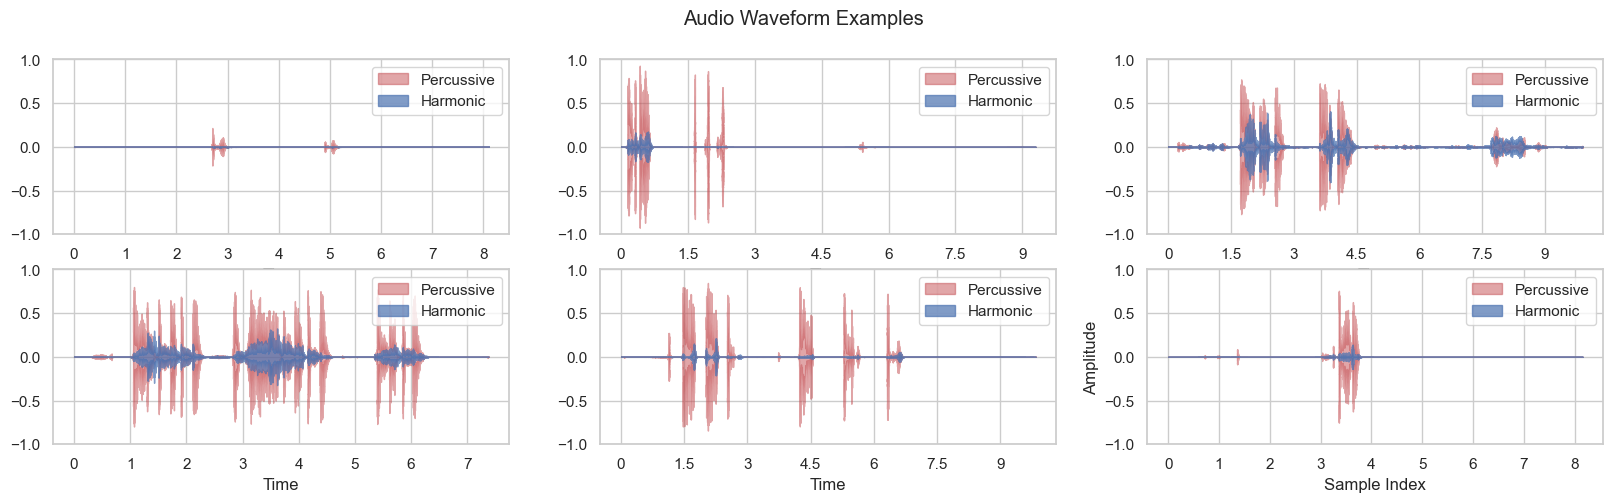

In [16]:
plt.figure(figsize=(20, 5))
sns.set(style="whitegrid")

for i, waveform in enumerate(waveforms):
    plt.subplot(2, 3, i + 1)

    y_harm, y_perc = librosa.effects.hpss(waveform)

    librosa.display.waveshow(y_perc, sr=SAMPLE_RATE, color='r', alpha=0.5, label='Percussive')
    librosa.display.waveshow(y_harm, sr=SAMPLE_RATE, alpha=0.7, label='Harmonic')

    plt.ylim(-1, 1)
    plt.legend()

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.suptitle(f'Audio Waveform Examples')

plt.savefig('waveform_examples.png', dpi=300, transparent=True)

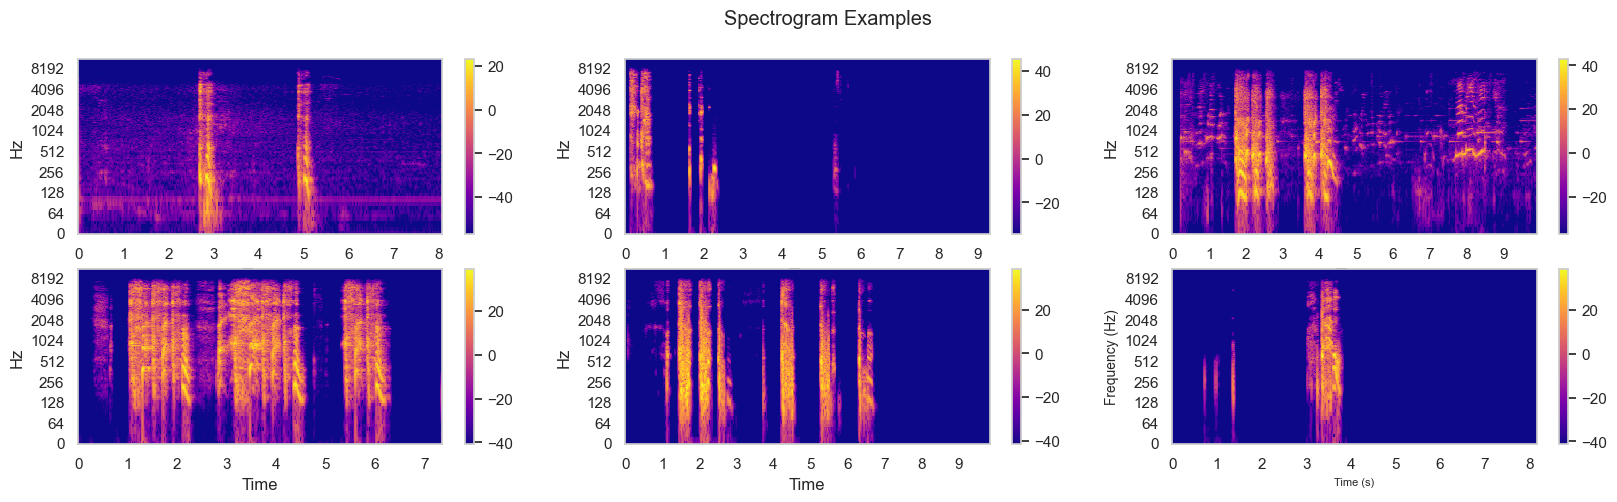

In [17]:
# Plot the spectrogram

plt.figure(figsize=(20, 5))
color_map = plt.cm.plasma

for i, waveform in enumerate(waveforms):
    plt.subplot(2, 3, i + 1)
    X = librosa.stft(waveform)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=SAMPLE_RATE, x_axis='time', cmap=color_map, y_axis='log')
    plt.colorbar()

plt.xlabel('Time (s)', fontsize=8)
plt.ylabel('Frequency (Hz)', fontsize=10)
plt.suptitle(f'Spectrogram Examples')

plt.savefig('spectrogram.png', dpi=300, transparent=True)

In [52]:
def train_mixtures(n_mixtures=3):
    # model = CoughMDN(n_mixtures=n_mixtures).cuda()
    model = ConvolutionalMDN(input_dimension=(1,), output_dimension=1, n_mixtures=n_mixtures).cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    train_losses_adam = []
    test_losses_adam = []

    print("Training with model with {} mixtures".format(n_mixtures))

    EPOCHS = 15
    progress_bar = tqdm(range(EPOCHS))
    for _ in progress_bar:
        train_losses_adam.append(
            train_loop(
                model,
                train_loader,
                optimizer,
                loss_function=mdn_loss,
                device=device,
            )
        )

        test_losses_adam.append(
            test_loop(model, test_loader, loss_function=mdn_loss, device=device)
        )

        progress_bar.set_description(
            f"Train loss: {train_losses_adam[-1]:.4f}, Test loss: {test_losses_adam[-1]:.4f}"
        )

    return model, train_losses_adam, test_losses_adam

In [13]:
model_3m, train_losses_3m, test_losses_3m = train_mixtures(n_mixtures=3)

Training with model with 3 mixtures


Train loss: -0.2776, Test loss: -0.2867: 100%|██████████| 15/15 [08:01<00:00, 32.12s/it]


In [53]:
model_2m, train_losses_2m, test_losses_2m = train_mixtures(n_mixtures=2)

Training with model with 2 mixtures


Train loss: 0.3828, Test loss: 0.2151:  67%|██████▋   | 10/15 [01:09<00:34,  6.97s/it]


IndexError: list index out of range

In [18]:
model_5m, train_losses_5m, test_losses_5m = train_mixtures(n_mixtures=5)

Training with model with 5 mixtures


Train loss: 5.0043, Test loss: 4.9392: 100%|██████████| 20/20 [05:46<00:00, 17.30s/it] 


In [15]:
cough_model_cnn = BasicCNN(input_dimension=(1, ), output_dimension=1).cuda()
#CoughCNN().cuda()

In [16]:
optimizer_cnn = torch.optim.Adam(cough_model_cnn.parameters(), lr=0.01)

train_losses_cnn = []
test_losses_cnn = []

mse_loss = torch.nn.MSELoss()

progress_bar = tqdm(range(EPOCHS))
for _ in progress_bar:
    train_losses_cnn.append(
        train_loop(
            cough_model_cnn,
            train_loader,
            optimizer_cnn,
            loss_function=mse_loss,
            device=device,
        )
    )

    test_losses_cnn.append(
        test_loop(cough_model_cnn, test_loader, loss_function=mse_loss, device=device)
    )

    progress_bar.set_description(
        f"Train loss: {train_losses_cnn[-1]:.4f}, Test loss: {test_losses_cnn[-1]:.4f}"
    )

Train loss: 0.1059, Test loss: 0.1083: 100%|██████████| 20/20 [08:50<00:00, 26.54s/it]


In [28]:
# Save the model

# torch.save(model_3m.state_dict(), 'cough_model_3m.pt')
# torch.save(model_2m.state_dict(), 'cough_model_2m.pt')
# torch.save(cough_model.state_dict(), 'cough_age_model.pt')
# torch.save(cough_model_cnn.state_dict(), 'cough_age_model_cnn.pt')

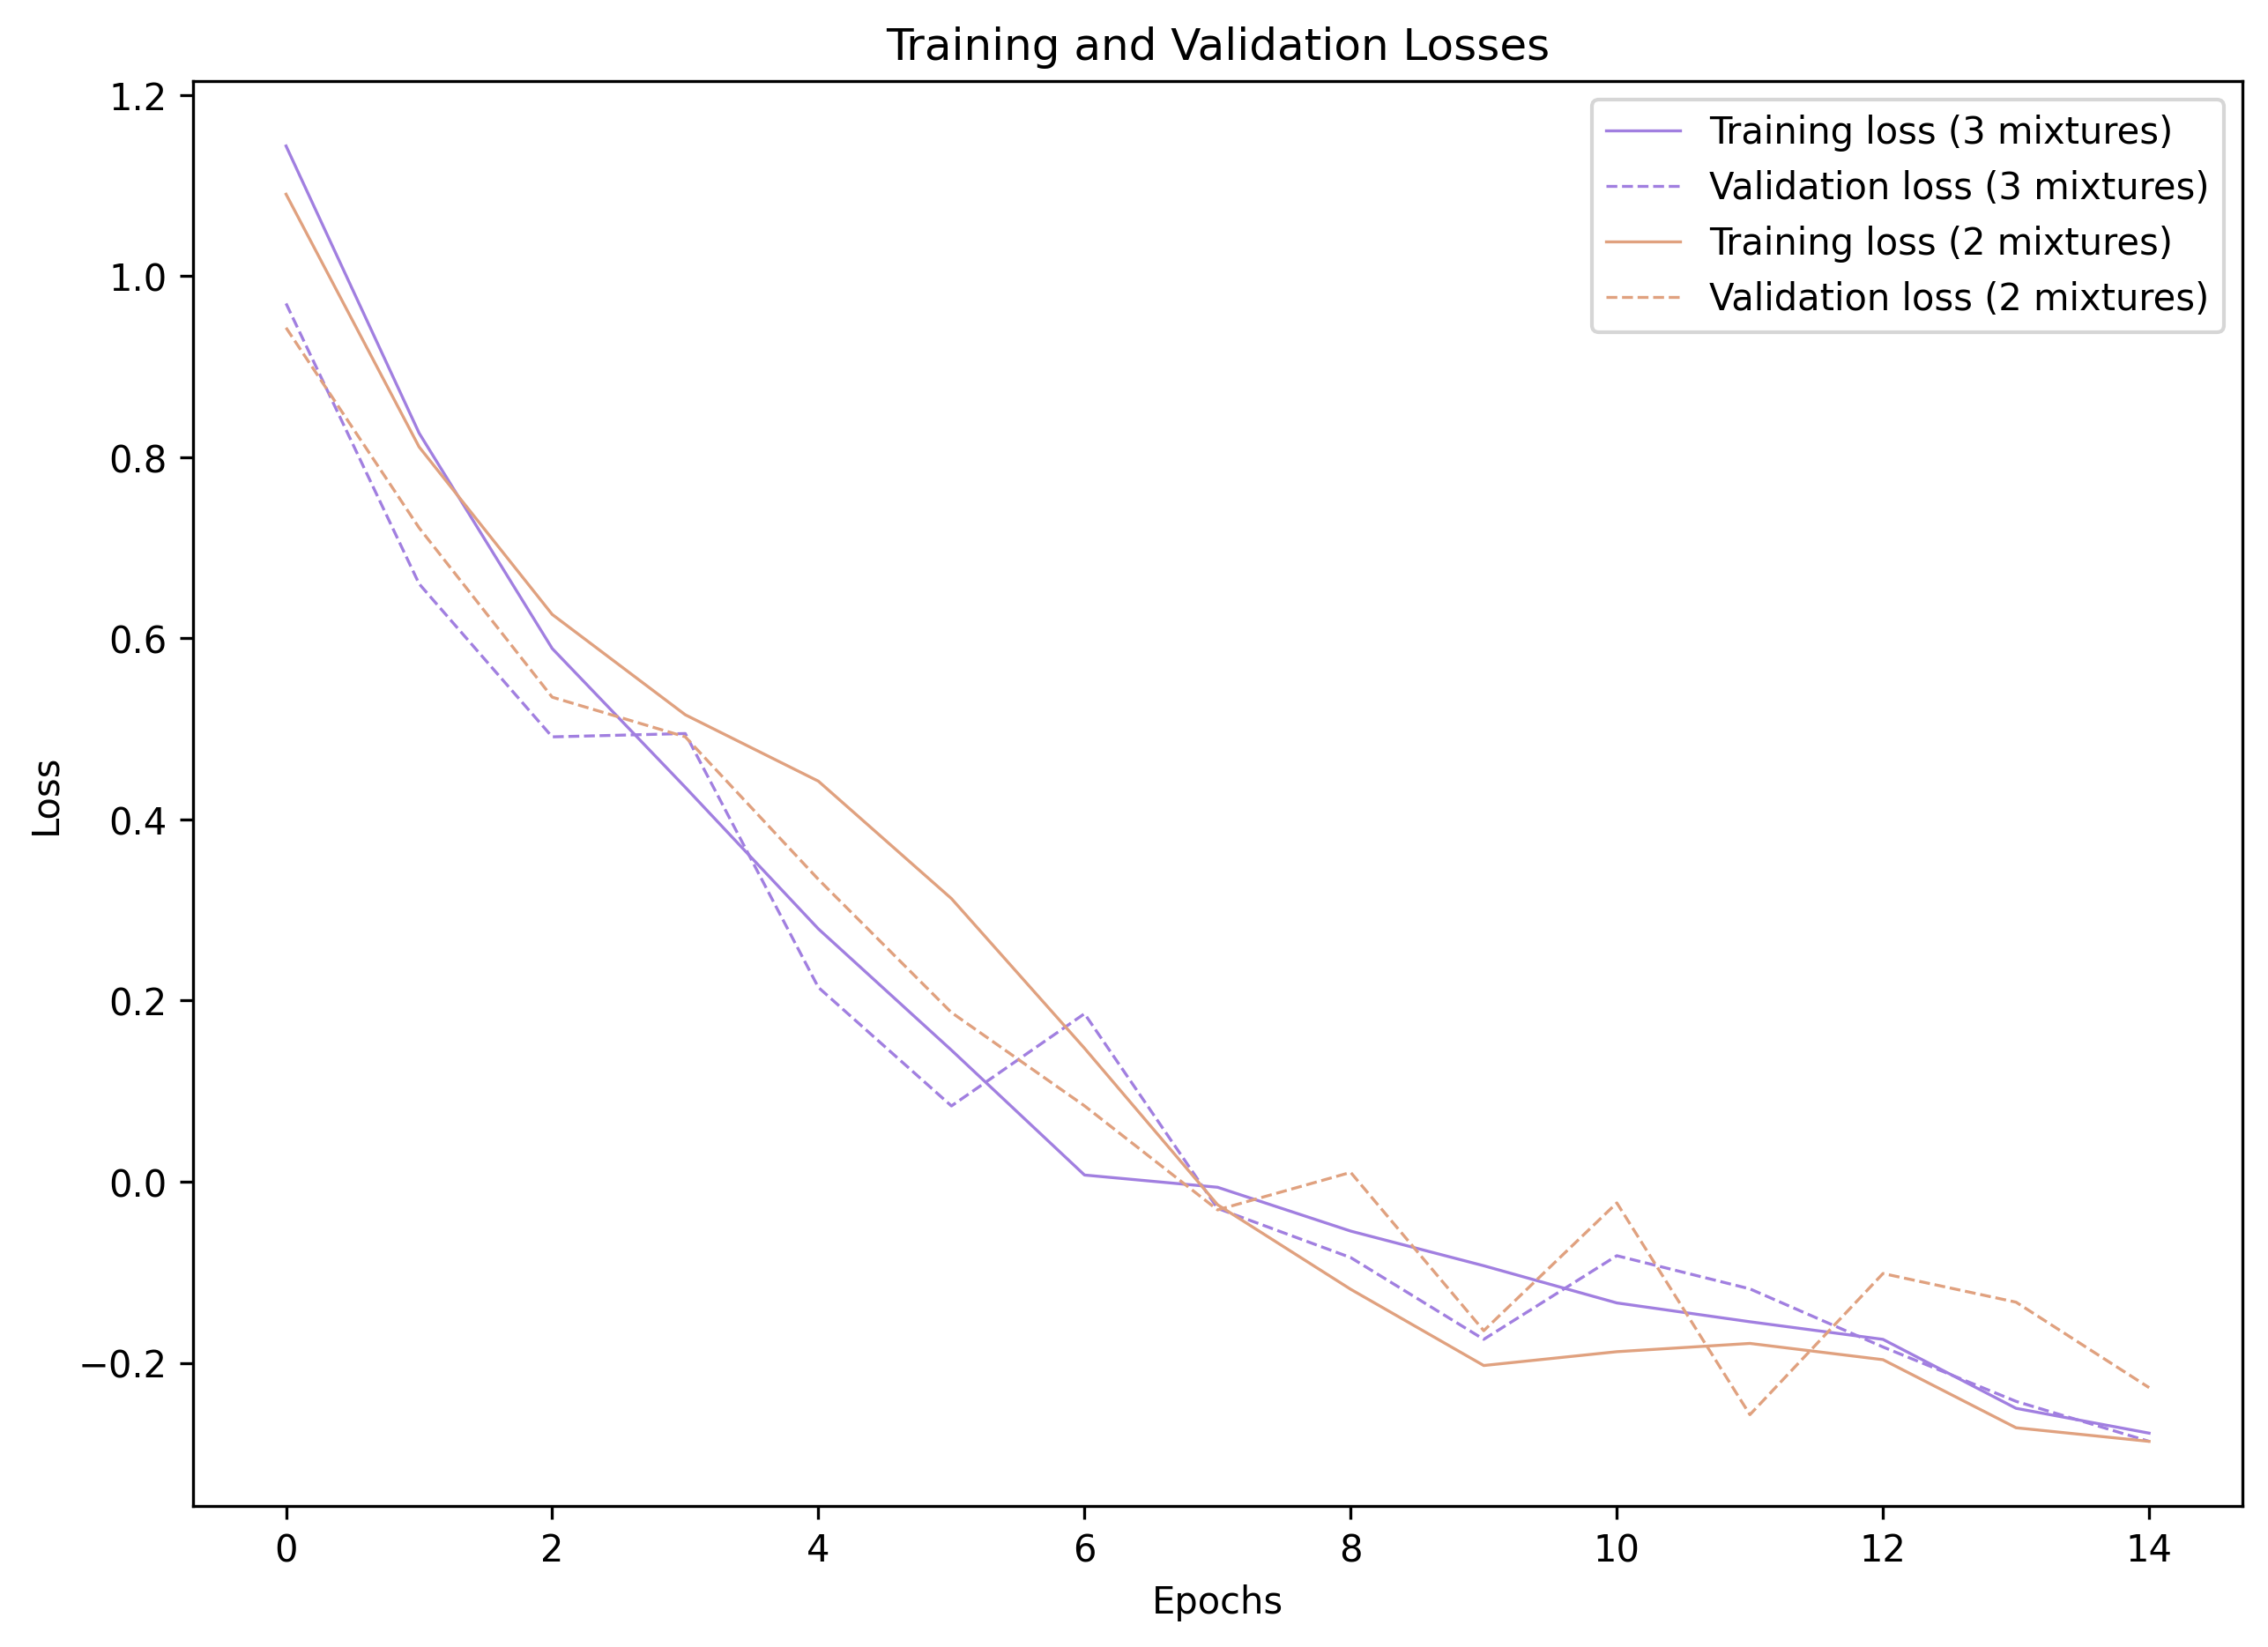

In [17]:
plt.figure(figsize=(10, 7), dpi=300)

plt.plot(train_losses_3m, label="Training loss (3 mixtures)", linewidth=0.8, color="#a17fe0")
plt.plot(test_losses_3m, label="Validation loss (3 mixtures)", linewidth=0.8, color="#a17fe0", linestyle="--")

plt.plot(train_losses_2m, label="Training loss (2 mixtures)", linewidth=0.8, color="#e0a17f")
plt.plot(test_losses_2m, label="Validation loss (2 mixtures)", linewidth=0.8, color="#e0a17f", linestyle="--")

# plt.plot(train_losses_5m, label="Training loss (5 mixtures)", linewidth=0.8, color="#7fe0a1")
# plt.plot(test_losses_5m, label="Validation loss (5 mixtures)", linewidth=0.8, color="#7fe0a1", linestyle="--")

# Make xticks integers
plt.xticks(np.arange(0, 15+1, 2))

plt.legend()
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("src/images/losses_cough_23m.png", dpi=300, transparent=True)

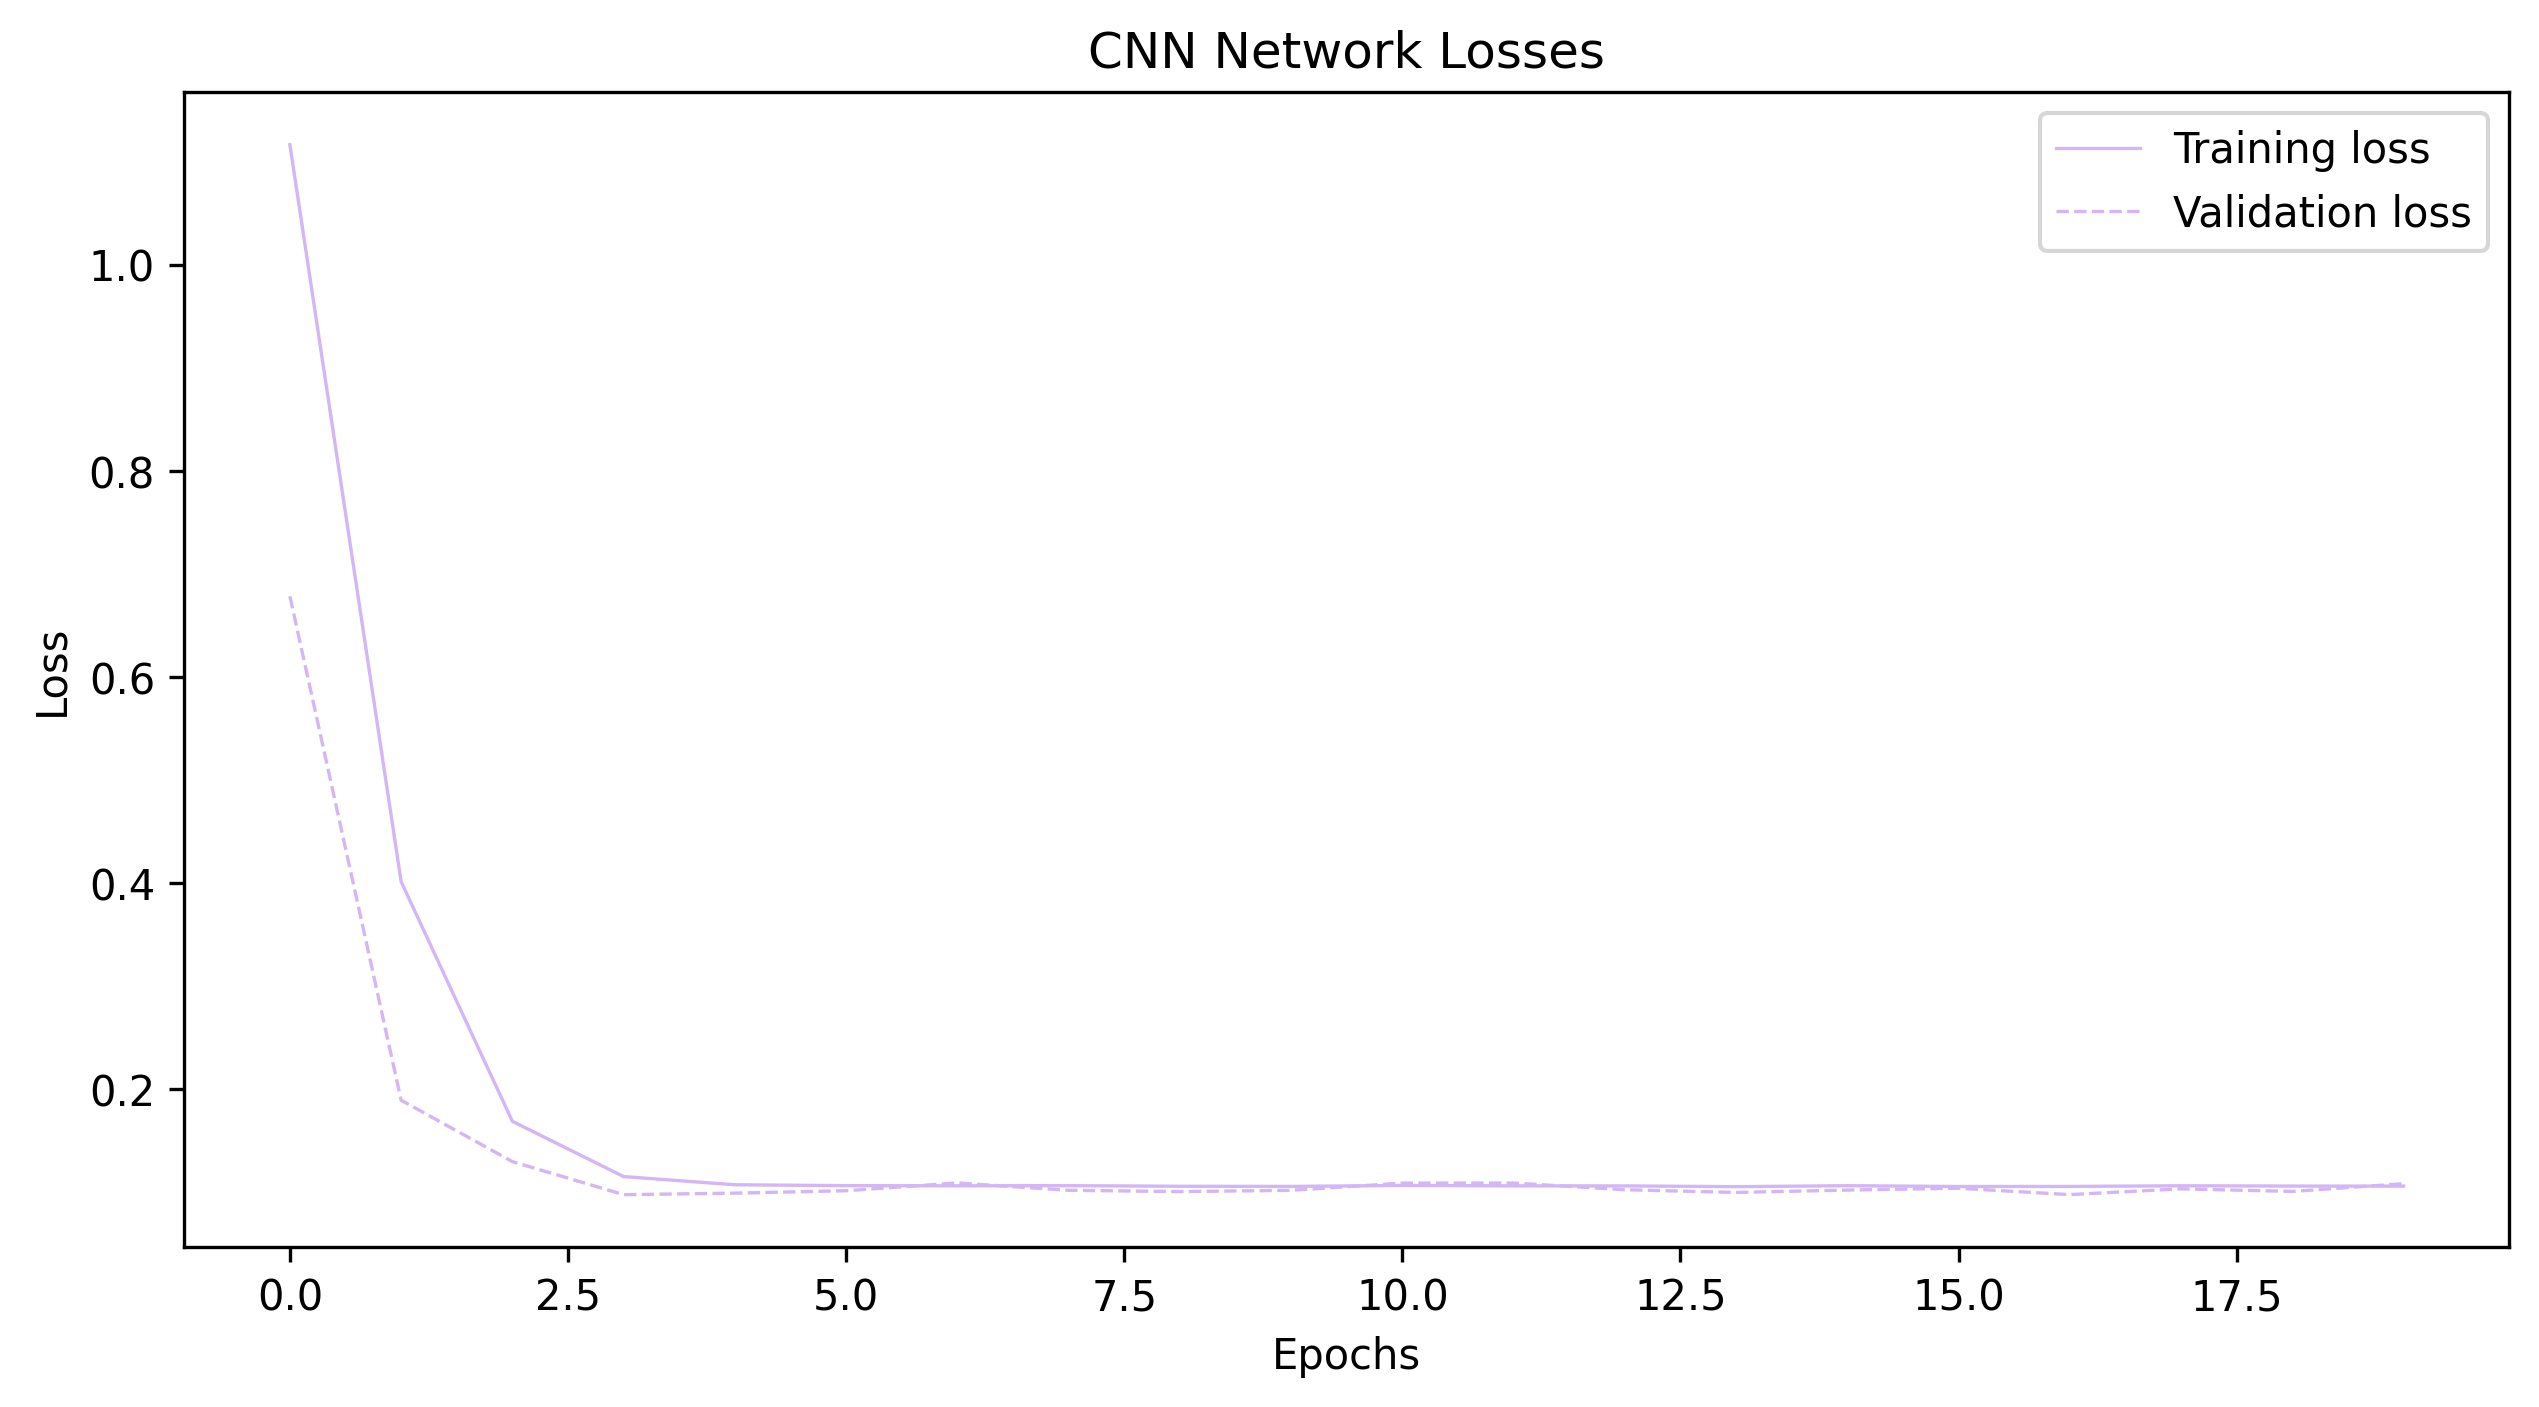

In [19]:
plt.figure(figsize=(10, 5), dpi=300)

plt.plot(train_losses_cnn, label="Training loss", linewidth=0.8, color="#d4b5f5")
plt.plot(test_losses_cnn, label="Validation loss", linewidth=0.8, color="#d4b5f5", linestyle="--")
plt.legend()
plt.title("CNN Network Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("src/images/losses_cough_cnn.png", dpi=300, transparent=True)

In [20]:
def extract_mixtures(model):
    # Get mu, sigma and pi from the test_loader
    mu, sigma, pi = [], [], []
    for waveform, label in test_loader:
        waveform = waveform.cuda()
        label = label.cuda()

        mu_, sigma_, pi_ = model(waveform)

        mu.append(mu_.detach().cpu().numpy())
        sigma.append(sigma_.detach().cpu().numpy())
        pi.append(pi_.detach().cpu().numpy())

    mu = np.concatenate(mu)
    sigma = np.concatenate(sigma)
    pi = np.concatenate(pi)

    indices = torch.arange(mu.shape[0])
    best_mu = mu[indices, np.argmax(pi, axis=1)]

    return mu, sigma, pi, best_mu

In [21]:
mu_3m, sigma_3m, pi_3m, top_mu_3m = extract_mixtures(model_3m)
mu_2m, sigma_2m, pi_2m, top_mu_2m = extract_mixtures(model_2m)
# mu_5m, sigma_5m, pi_5m, top_mu_5m = extract_mixtures(model_5m)

In [47]:
mu_3m.shape, sigma_3m.shape, pi_3m.shape, top_mu_3m.shape

((712, 3, 1), (712, 3), (712, 3), (712, 1))

In [22]:
true_labels = []
for sample in test_loader.dataset:
    if sample is not None:
        true_labels.append(sample[1][0])
true_labels = np.array(true_labels)

In [23]:
# Compute MSE loss between true labels and mu_max

mse_loss = torch.nn.MSELoss()
mdn_error_3m = mse_loss(torch.tensor(top_mu_3m), torch.tensor(true_labels))
mdn_error_2m = mse_loss(torch.tensor(top_mu_2m), torch.tensor(true_labels))
# mdn_error_5m = mse_loss(torch.tensor(top_mu_5m), torch.tensor(true_labels))

print("MDN error (3 mixtures): {:.4f}".format(mdn_error_3m))
print("MDN error (2 mixtures): {:.4f}".format(mdn_error_2m))
# print("MDN error (5 mixtures): {:.4f}".format(mdn_error_5m))

MDN error (3 mixtures): 0.1344
MDN error (2 mixtures): 0.1289


c:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([698])) that is different to the input size (torch.Size([698, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
# Compute MSE loss between true labels and the cough_model_cnn predictions

cough_model_cnn.eval()

cnn_predictions = []
for waveform, label in test_loader:
    waveform = waveform.cuda()
    label = label.cuda()

    cnn_predictions.append(cough_model_cnn(waveform).detach().cpu().numpy())

cnn_predictions = np.concatenate(cnn_predictions)

cnn_error = mse_loss(torch.tensor(cnn_predictions), torch.tensor(true_labels))

In [25]:
print(f"CNN error: {cnn_error:.4f}")

CNN error: 0.1020


In [26]:
def extract_mixtures_final(model):
    # Get mu, sigma and pi from the test_loader
    mu, sigma, pi, truth = [], [], [], []
    for waveform, label in test_loader:
        waveform = waveform.cuda()
        label = label.cuda()

        mu_, sigma_, pi_ = model(waveform)

        mu.append(mu_.detach().cpu().numpy())
        sigma.append(sigma_.detach().cpu().numpy())
        pi.append(pi_.detach().cpu().numpy())

        truth.append(label.detach().cpu().numpy())

    mu = np.concatenate(mu)
    sigma = np.concatenate(sigma)
    pi = np.concatenate(pi)
    truth = np.concatenate(truth)

    indices = torch.arange(mu.shape[0])
    best_mu = mu[indices, np.argmax(pi, axis=1)]

    return mu, sigma, pi, best_mu, truth

In [27]:
_mu_3m, _sigma_3m, _pi_3m, _top_mu_3m, _truth_3m = extract_mixtures_final(model_3m)
_mu_2m, _sigma_2m, _pi_2m, _top_mu_2m, _truth_2m = extract_mixtures_final(model_2m)

In [199]:
# true_mu_2n = 25*_top_mu_2m + 50
# true_mu_3n = 25*_top_mu_3m + 50

# true_label = 25*true_labels + 50

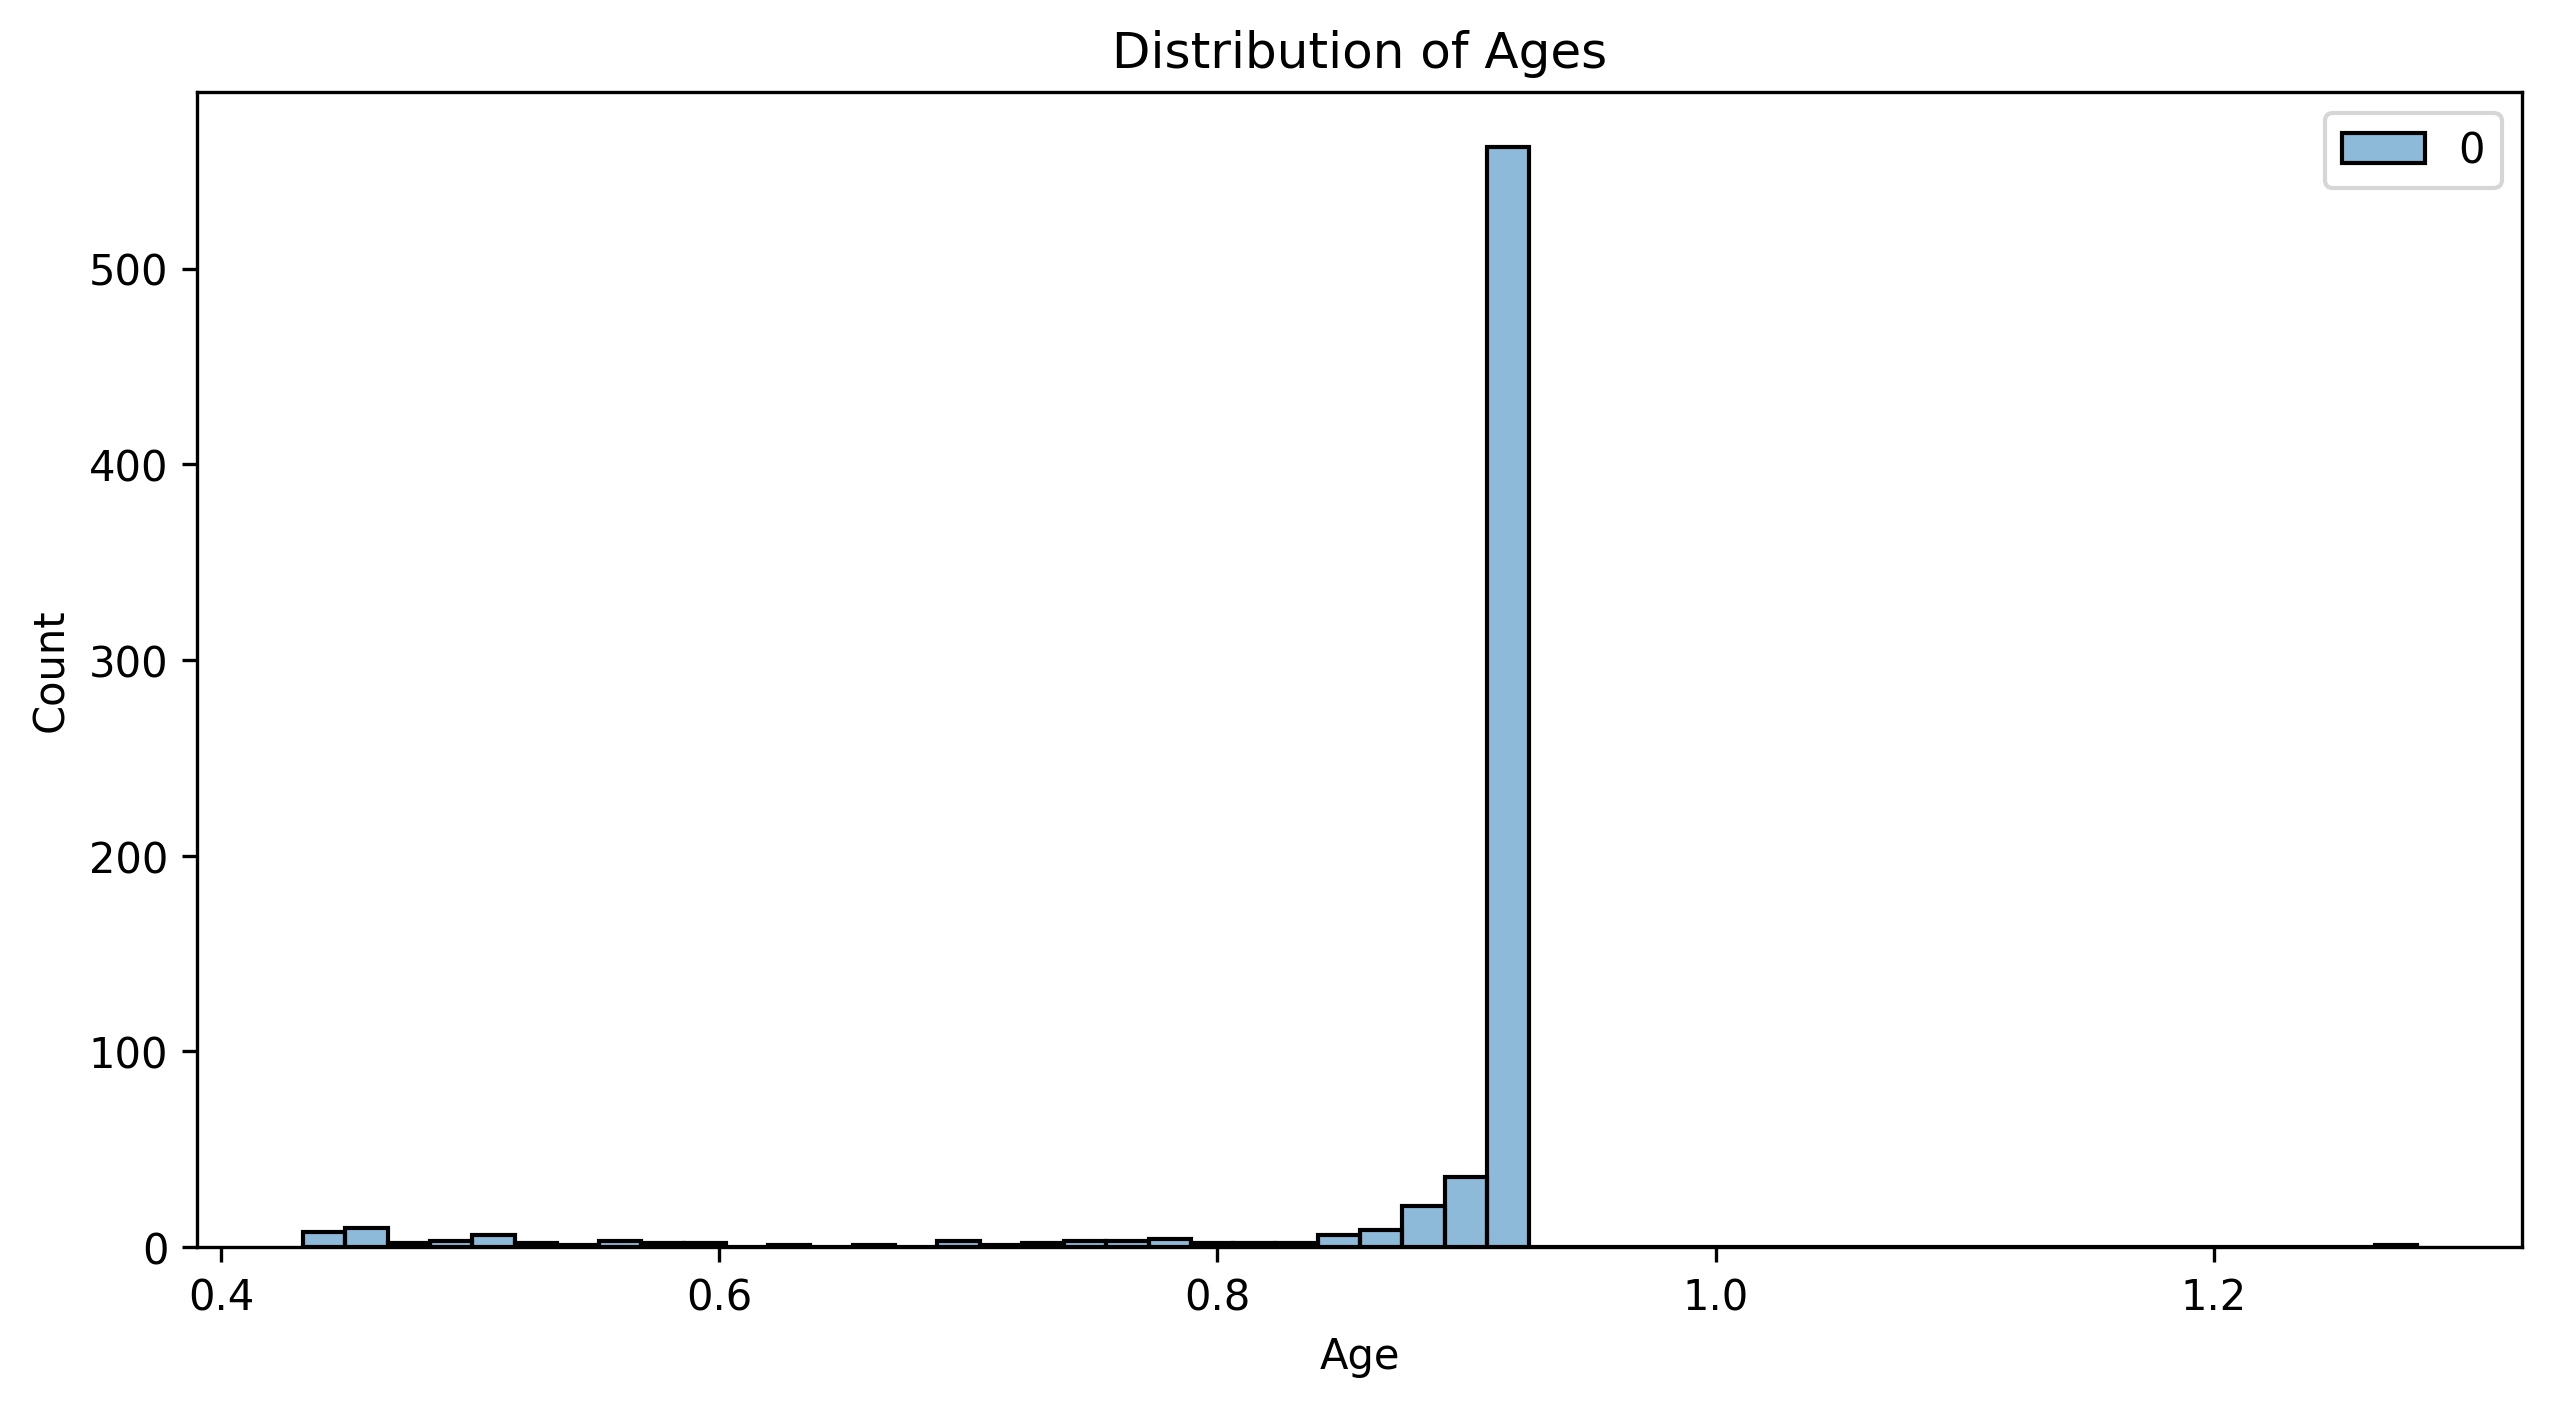

In [28]:
import seaborn as sns

# Plot the distribution of the true labels
plt.figure(figsize=(10, 5), dpi=300)
# sns.histplot(true_label, bins=50, color="#a17fe0")
sns.histplot(_top_mu_2m, bins=50, color="#e0a17f", alpha=0.5)
# sns.histplot(true_mu_3n, bins=50, color="#7fe0a1", alpha=0.5)
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig("src/images/age_distribution.png", dpi=300, transparent=True)

In [68]:
true_labels, list(pi_3m)

(array([0.68, 0.18, 0.62, 0.35, 0.45, 0.13, 0.3 , 0.4 , 0.3 , 0.35, 0.31,
        0.51, 0.38, 0.21, 0.18, 0.5 , 0.23, 0.51, 0.37, 0.15, 0.39, 0.35,
        0.19, 0.18, 0.31, 0.3 , 0.3 , 0.5 , 0.36, 0.3 , 0.32, 0.24, 0.5 ,
        0.27, 0.26, 0.26, 0.35, 0.21, 0.35, 0.23, 0.55, 0.36, 0.6 , 0.48,
        0.49, 0.19, 0.18, 0.16, 0.57, 0.38, 0.24, 0.49, 0.33, 0.27, 0.24,
        0.34, 0.44, 0.52, 0.17, 0.39, 0.51, 0.51, 0.14, 0.28, 0.19, 0.48,
        0.49, 0.2 , 0.33, 0.36, 0.44, 0.27, 0.38, 0.57, 0.69, 0.37, 0.22,
        0.19, 0.2 , 0.12, 0.33, 0.47, 0.29, 0.62, 0.21, 0.28, 0.14, 0.3 ,
        0.55, 0.23, 0.37, 0.35, 0.33, 0.6 , 0.3 , 0.21, 0.11, 0.47, 0.26,
        0.38, 0.34, 0.2 , 0.33, 0.18, 0.35, 0.24, 0.53, 0.46, 0.24, 0.36,
        0.4 , 0.33, 0.58, 0.59, 0.42, 0.16, 0.16, 0.38, 0.48, 0.25, 0.45,
        0.62, 0.18, 0.27, 0.31, 0.46, 0.35, 0.68, 0.63, 0.25, 0.14, 0.53,
        0.35, 0.3 , 0.29, 0.29, 0.47, 0.4 , 0.29, 0.3 , 0.54, 0.4 , 0.16,
        0.51, 0.16, 0.47, 0.56, 0.37, 

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [150]:
# def age_scaler(age):
#     return (age - 50) / 25

In [44]:
# Get samples of the test_loader with label between 0.4 and 0.5

def plot_range(model, min_range, max_range, num=10, mixtures=3, seed=42):
    # indices = np.where((true_labels >= min_range) & (true_labels <= max_range))[0]
    # indices = [idx for idx in indices if test_loader.dataset[idx] is not None]
    # print(f"Found {len(indices)} samples in the range {min_range} - {max_range}")

    indices = [i for i, sample in enumerate(test_loader.dataset) if sample is not None if min_range <= sample[1] <= max_range and sample is not None]

    # np.random.seed(seed)
    indices = np.random.choice(indices, num)
    indices = np.unique(indices)
    samples = [test_loader.dataset[i] for i in indices]
    # Add true label to each sample
    samples = [(sample[0], sample[1], true_labels[i], idx) for i, (sample, idx) in enumerate(zip(samples, indices))]
    samples = sorted(samples, key=lambda x: x[2])

    # palette = ["#a17fe0", "#e0a17f", "#7fe0a1", "#d4b5f5", "#f5d4b5", "#b5f5d4"]#plt.cm.plasma(np.linspace(0, 1, mixtures))
    palette = ["#7e5bb2", "#b2795b", "#5b7e79", "#9e8ac6", "#c6a98a", "#8ac6a9"]
    palette = palette[:mixtures]
    #plt.cm.plasma(np.linspace(0, 1, mixtures))

    fig, ax = plt.subplots(figsize=(20, 10), dpi=300)

    for i in range(len(samples)):
        waveform, label, true_label, idx = samples[i]

        waveform = waveform.cuda()
        label = label.cuda()

        mu_, sigma_, pi_ = model(waveform.unsqueeze(0))
        pi_values = pi_.detach().cpu().numpy().squeeze()
        mu_values = mu_.detach().cpu().numpy().squeeze()

        print(mu_, label)

        x_values = [i for _ in range(len(pi_values))]
        ax.scatter(x_values, pi_values, label=f"Sample {i}", color=palette)
        # Add text to each point

        offsets = [0.1, 0.01]
        for j in range(len(pi_values)):
            ax.text(x_values[j] + 0.1, pi_values[j] + 0.015*(j), f"{int(mu_values[j]*100)}%", fontsize=8, color=palette[j])

        max_index = np.argmax(pi_values)
        prediction = mu_values[max_index]

        # Add prediction to sample
        samples[i] = (waveform, label, true_label, prediction, idx)

    # Set x-axis ticks to the index of each sample
    ax.set_xticks(np.arange(len(samples)))
    ax.set_xticklabels([f"{int(samples[i][3]*100)}% / {int(samples[i][1]*100)}%" for i in range(len(samples))])# ({samples[i][3]})

    plt.legend(handles=[mpatches.Patch(color=palette[i], label=f"Mixture {i}") for i in range(mixtures)])

    # Set labels and title
    ax.set_xlabel('Age (predicted / true age)')
    ax.set_ylabel('Pi Values')
    ax.set_title('Pi Values for Each Sample')

    plt.show()


tensor([[[0.8537],
         [0.9289],
         [0.2473]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2815], device='cuda:0')
tensor([[[0.8613],
         [0.4929],
         [0.2513]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.1462], device='cuda:0')
tensor([[[0.8547],
         [0.8744],
         [0.2480]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2106], device='cuda:0')
tensor([[[0.8549],
         [0.8609],
         [0.2481]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2785], device='cuda:0')
tensor([[[0.8537],
         [0.9289],
         [0.2473]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.0323], device='cuda:0')
tensor([[[0.8542],
         [0.8999],
         [0.2476]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.3802], device='cuda:0')
tensor([[[0.8537],
         [0.9292],
         [0.2473]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2214], device='cuda:0')

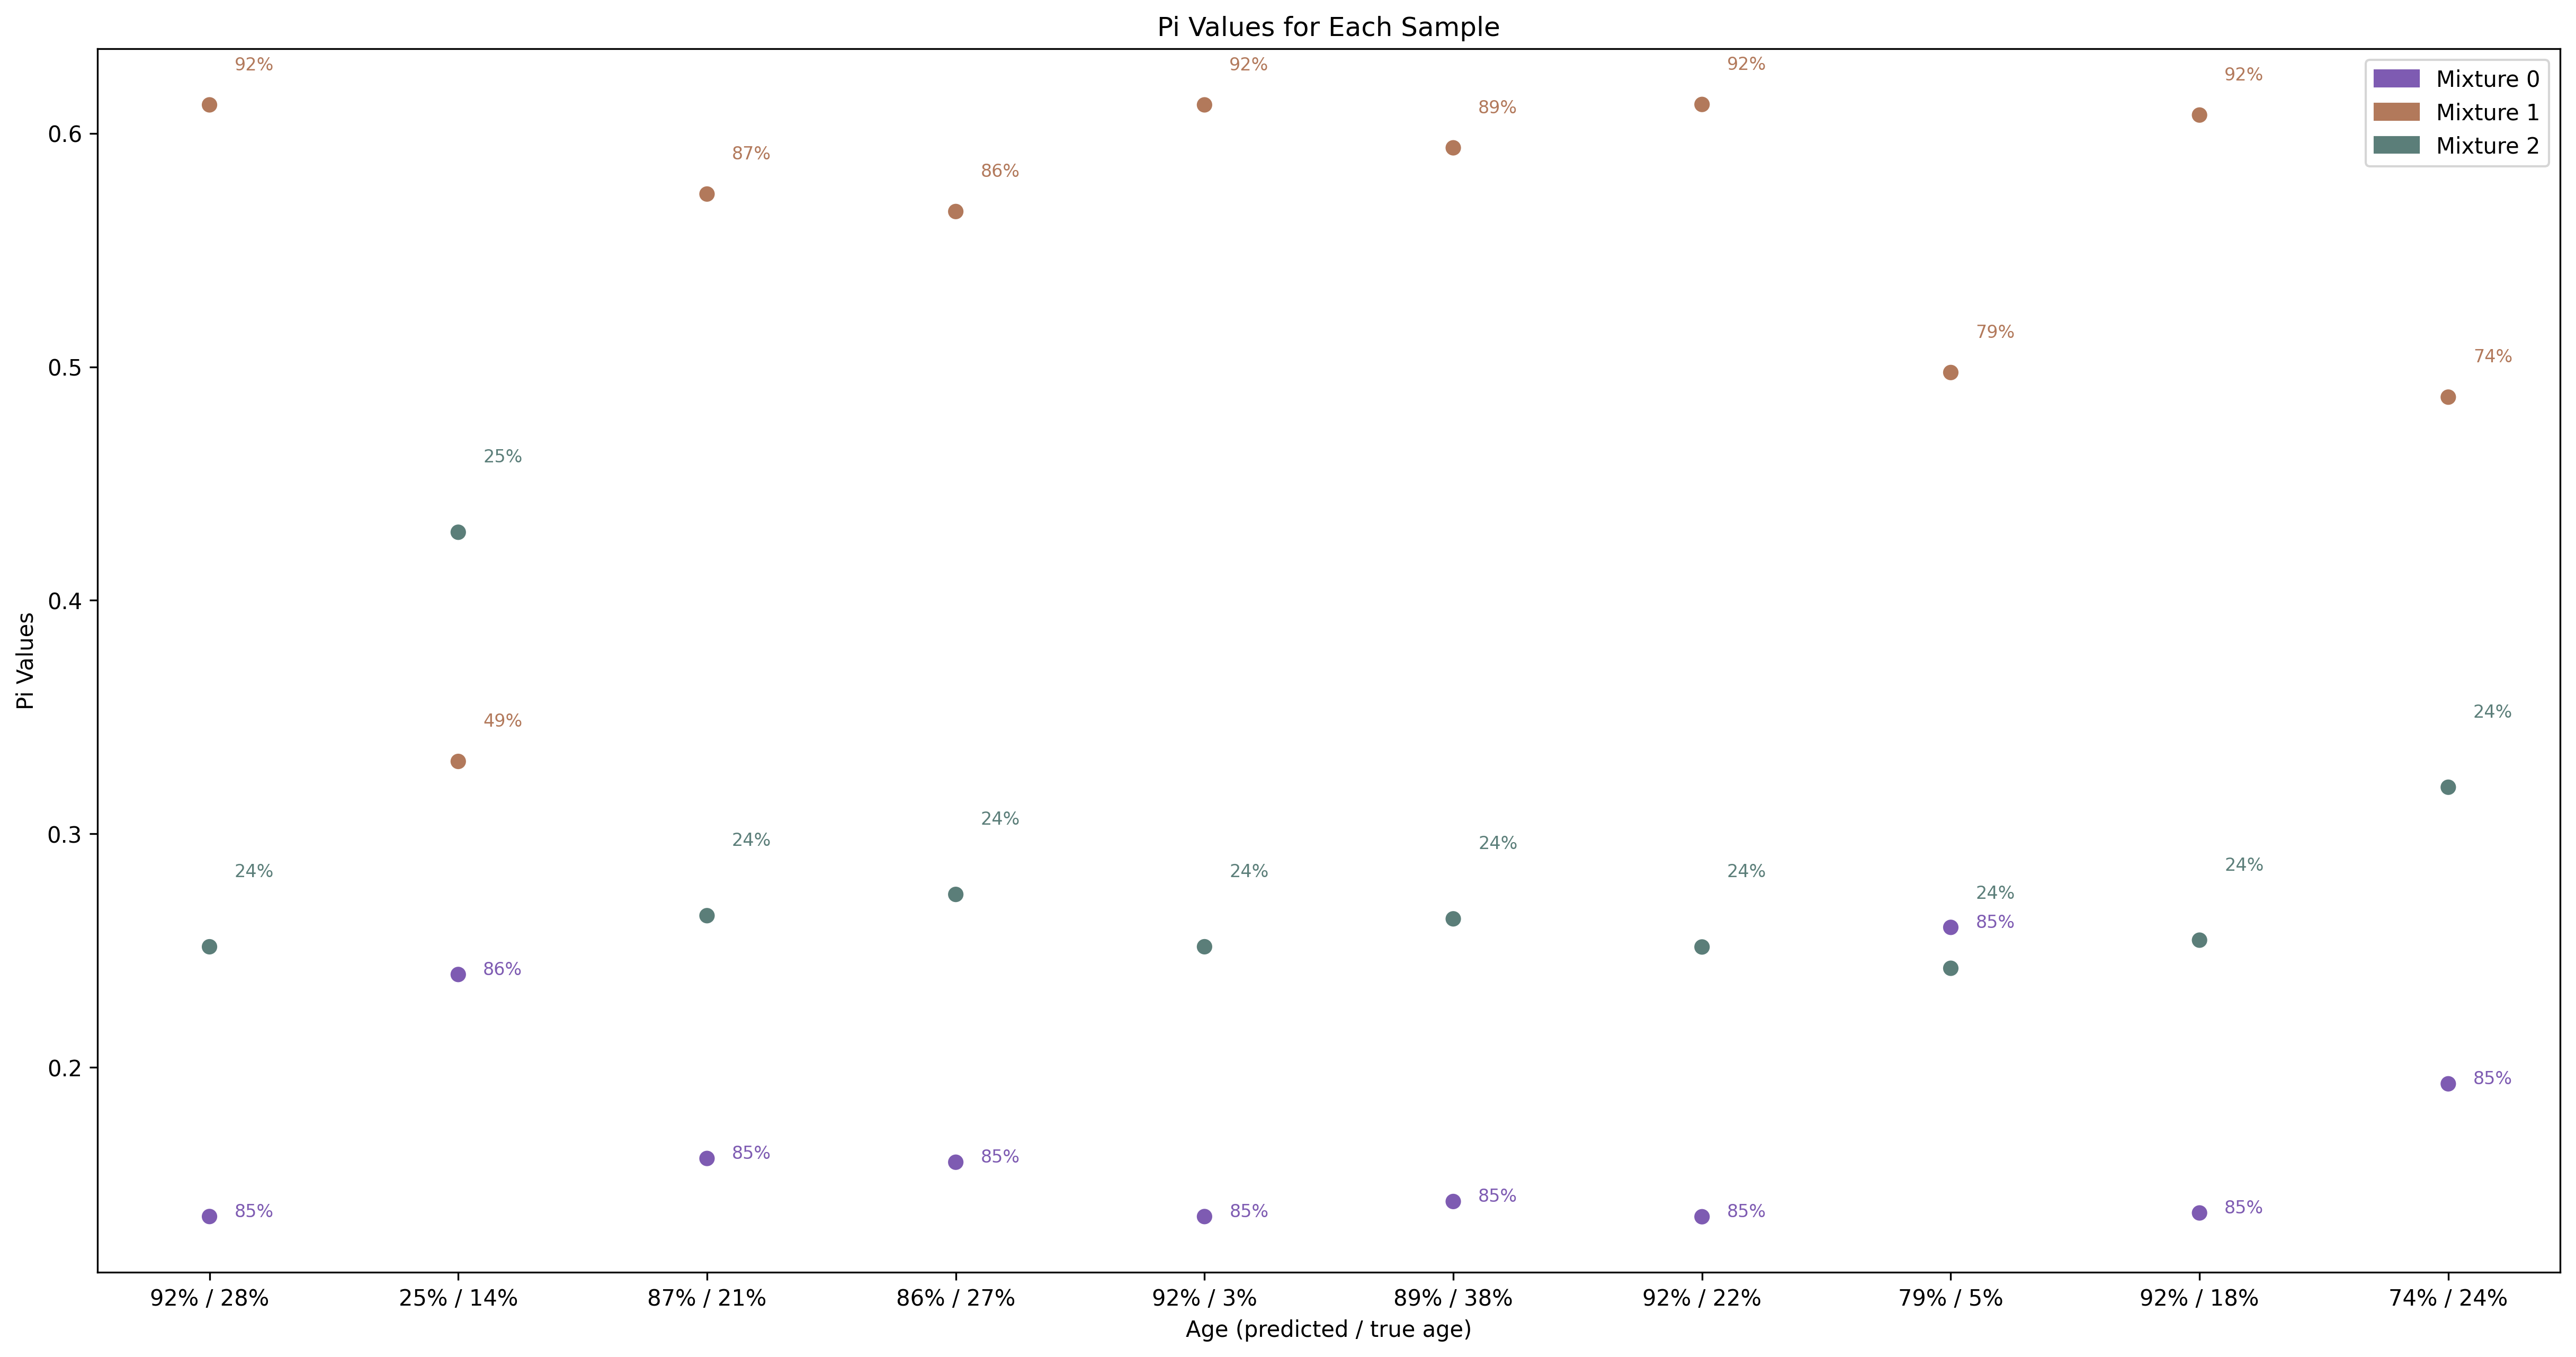

tensor([[[0.9165],
         [0.4172]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.0048], device='cuda:0')
tensor([[[0.9095],
         [0.4177]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.4671], device='cuda:0')
tensor([[[0.9166],
         [0.4172]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2427], device='cuda:0')
tensor([[[0.9009],
         [0.4185]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.0530], device='cuda:0')
tensor([[[0.6405],
         [0.4357]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.0458], device='cuda:0')
tensor([[[0.9165],
         [0.4172]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.0223], device='cuda:0')
tensor([[[0.7136],
         [0.4322]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.4689], device='cuda:0')
tensor([[[0.8442],
         [0.4228]]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) tensor([0.2785], device='cuda:0')
tensor([

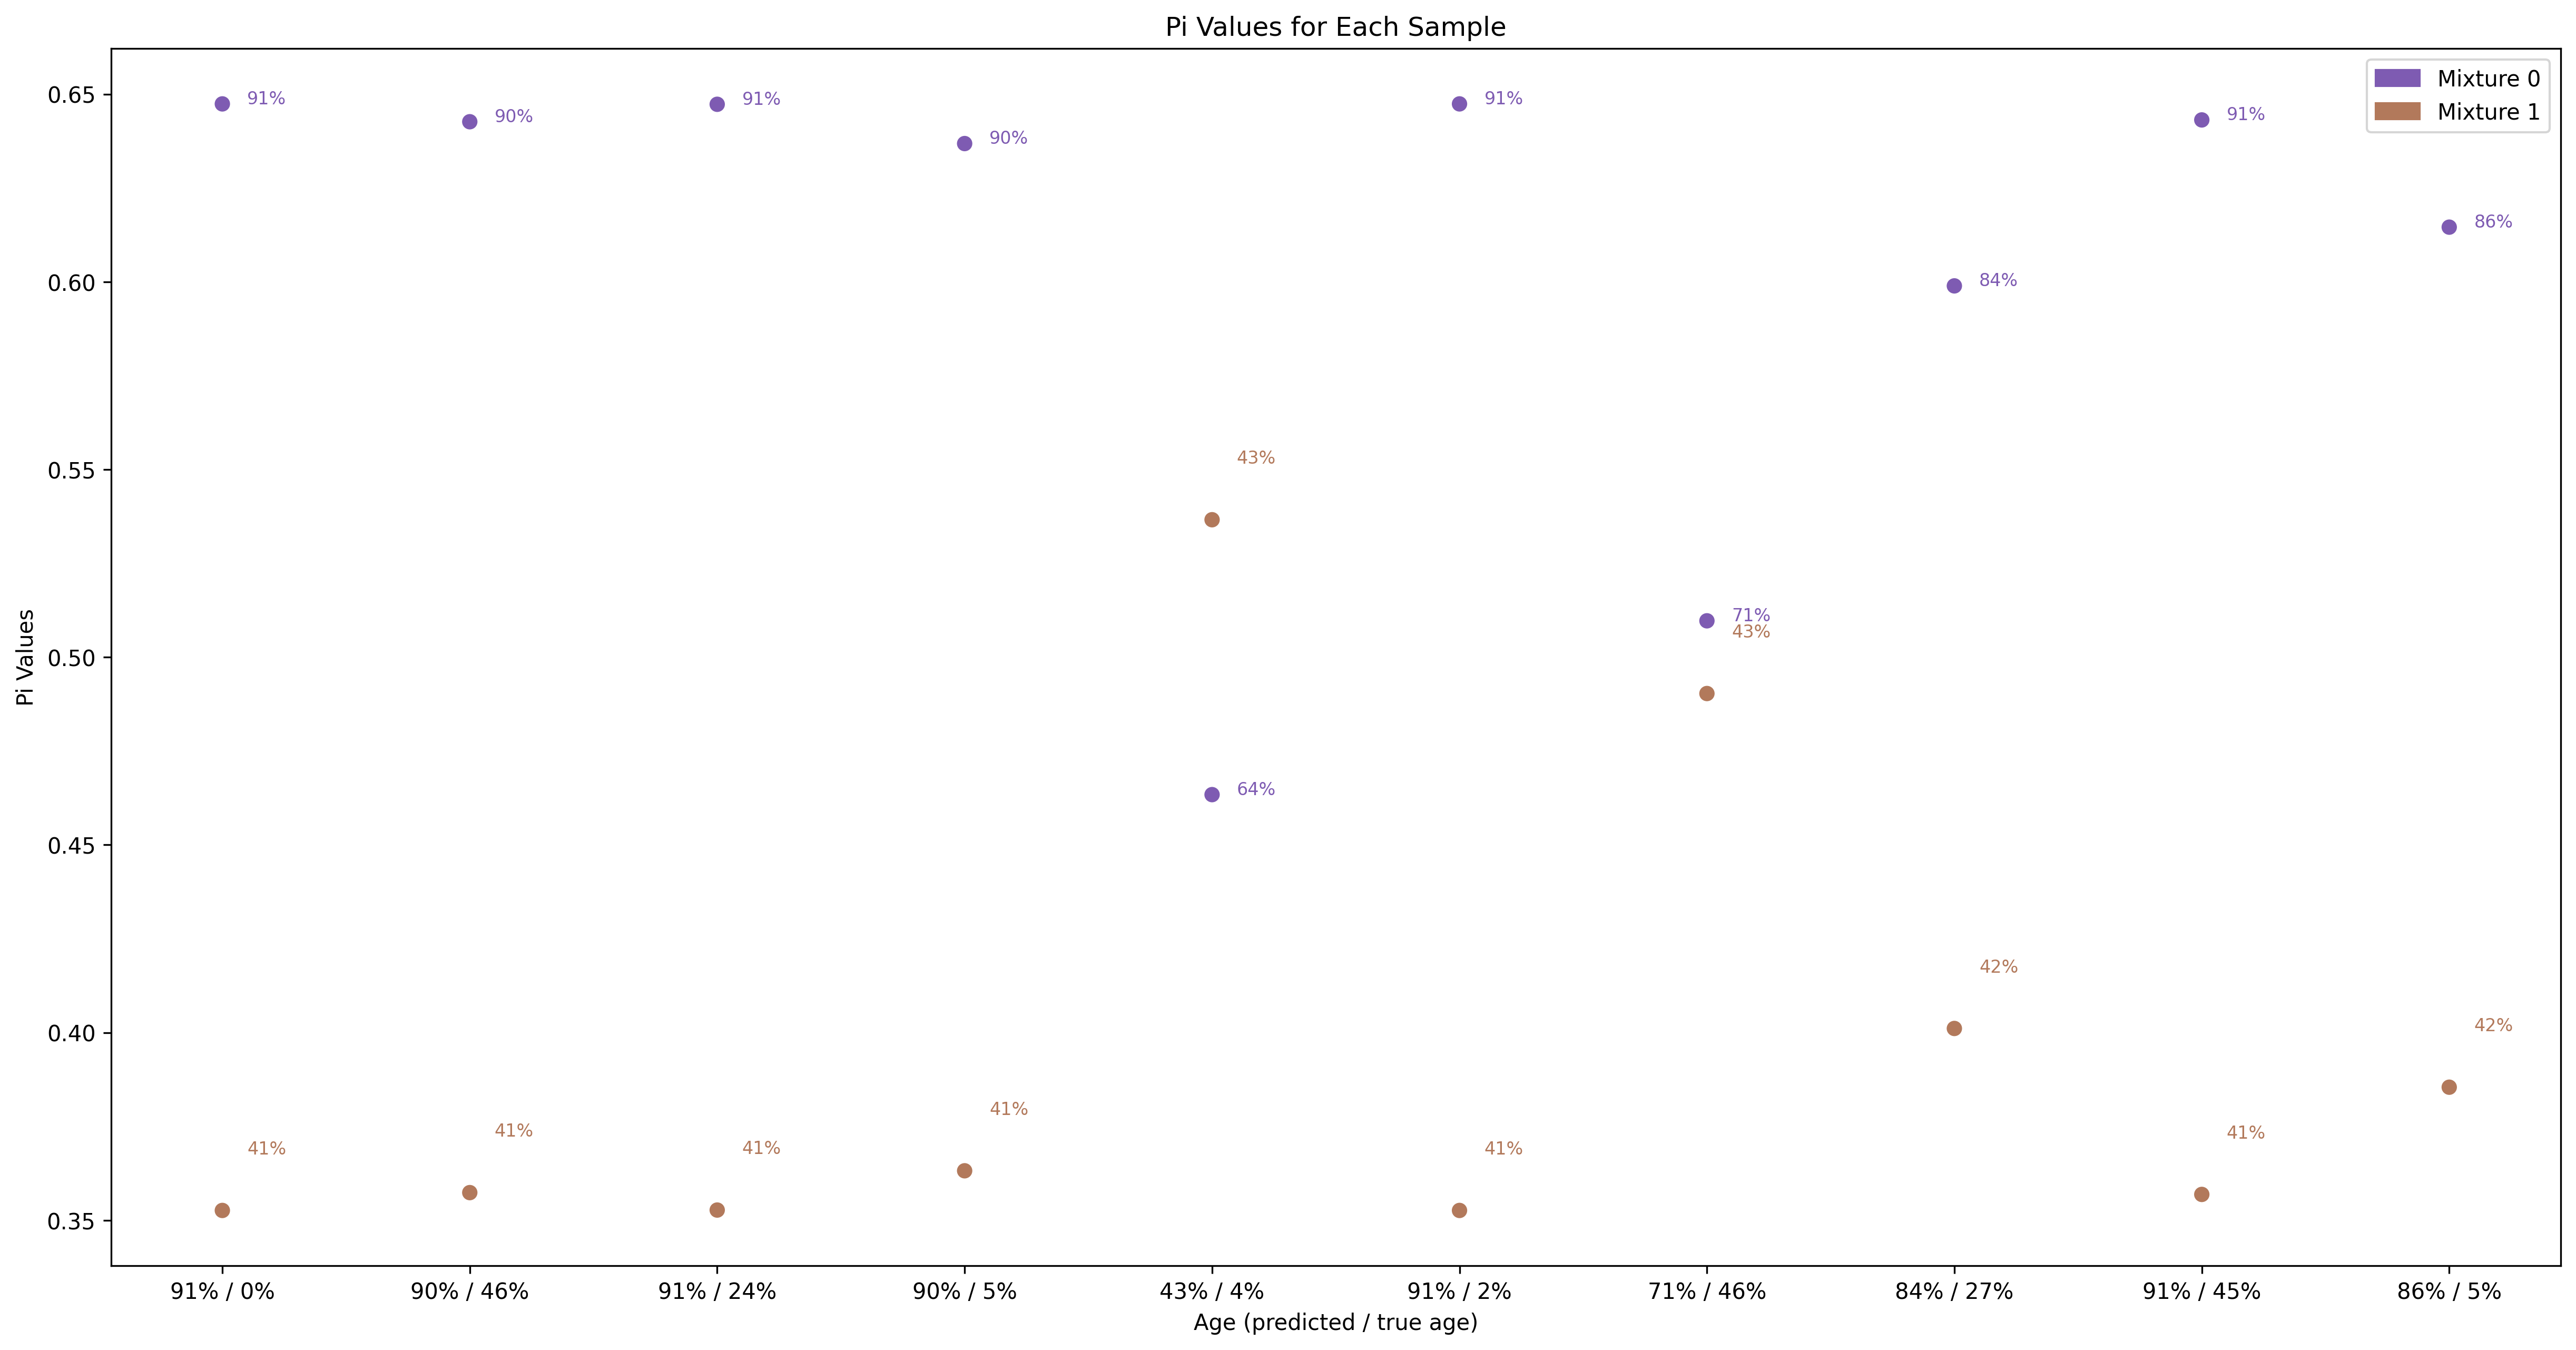

In [45]:
# plot_range(model_3m, age_scaler(35), age_scaler(55), num=10, mixtures=3, seed=5)
# plot_range(model_2m, age_scaler(35), age_scaler(55), num=10, mixtures=2, seed=5)
plot_range(model_3m, 0.0, 0.5, num=10, mixtures=3, seed=5)
plot_range(model_2m, 0.0, 0.5, num=10, mixtures=2, seed=5)
# plot_range(model_5m, 32, 45, num=30, mixtures=5, seed=12)